In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import math

In [2]:
TARGET_SLICE_COUNT = 64  # Number of slices per patient
TARGET_SLICE_DIMENSIONS = (128, 128)  # Dimensions of each slice

In [4]:
# Load preprocessed data
X_train3 = np.load("/kaggle/input/dataset/X_train.npy")
y_train3 = np.load("/kaggle/input/dataset/y_train.npy")
X_valid3 = np.load("/kaggle/input/dataset/X_valid.npy")
y_valid3 = np.load("/kaggle/input/dataset/y_valid.npy")

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Reshape

In [6]:
model_cnn3d = Sequential([
    Conv3D(32, (3, 3, 3), activation="relu", input_shape=(TARGET_SLICE_COUNT, *TARGET_SLICE_DIMENSIONS, 1)),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(64, (3, 3, 3), activation="relu"),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(1, activation="sigmoid")  # Binary classification: cancer/no cancer
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model_cnn3d.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", "Precision", "Recall", "AUC"])

In [9]:
model_cnn3d.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 62, 126, 126,   │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 31, 63, 63, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 29, 61, 61, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 14, 30, 30, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 806400)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   103,219,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,275,713 (393.97 MB)

 Trainable params: 103,275,713 (393.97 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Assuming `train_data` and `val_data` are prepared
history_cnn3d = model_cnn3d.fit(X_train3, y_train3,
                    validation_data=(X_valid3, y_valid3),
                    epochs=25,
                    verbose=1)

Epoch 1/25


I0000 00:00:1732817761.263079     111 service.cc:145] XLA service 0x7bcb7c00c610 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732817761.263135     111 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732817761.263139     111 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
2024-11-28 18:16:13.114842: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,31,63,63]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,29,61,61]{4,3,2,1,0}, f32[64,32,3,3,3]{4,3,2,1,0}), window={size=3x3x3}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-28 18:16:15.945595: E external/local_xla

1/2 ━━━━━━━━━━━━━━━━━━━━ 31s 31s/step - AUC: 0.5294 - Precision: 1.0000 - Recall: 0.0588 - accuracy: 0.5000 - loss: 132.1767

2024-11-28 18:16:37.375405: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[19,32,31,63,63]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[19,64,29,61,61]{4,3,2,1,0}, f32[64,32,3,3,3]{4,3,2,1,0}), window={size=3x3x3}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-11-28 18:16:38.722526: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 2.347221617s
Trying algorithm eng0{} for conv (f32[19,32,31,63,63]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[19,64,29,61,61]{4,3,2,1,0}, f32[64,32,3,3,3]{4,3,2,1,0}), window={size=3x3x3}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn

2/2 ━━━━━━━━━━━━━━━━━━━━ 58s 26s/step - AUC: 0.4888 - Precision: 0.6333 - Recall: 0.2596 - accuracy: 0.4804 - loss: 31104.2988 - val_AUC: 0.5000 - val_Precision: 0.5217 - val_Recall: 1.0000 - val_accuracy: 0.5217 - val_loss: 22398.8809
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 758ms/step - AUC: 0.5349 - Precision: 0.5300 - Recall: 0.8133 - accuracy: 0.5431 - loss: 15458.5977 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.4783 - val_loss: 876.7339
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 759ms/step - AUC: 0.5046 - Precision: 0.4000 - Recall: 0.0800 - accuracy: 0.5196 - loss: 581.6713 - val_AUC: 0.5000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.4783 - val_loss: 93.1389
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 755ms/step - AUC: 0.6478 - Precision: 0.6389 - Recall: 0.5933 - accuracy: 0.6528 - loss: 85.3510 - val_AUC: 0.6667 - val_Precision: 1.0000 - val_Recall: 0.2500 - val_accuracy: 0.6087 - val_loss: 8.1205
Epoch 5/25
2/2 ━━━

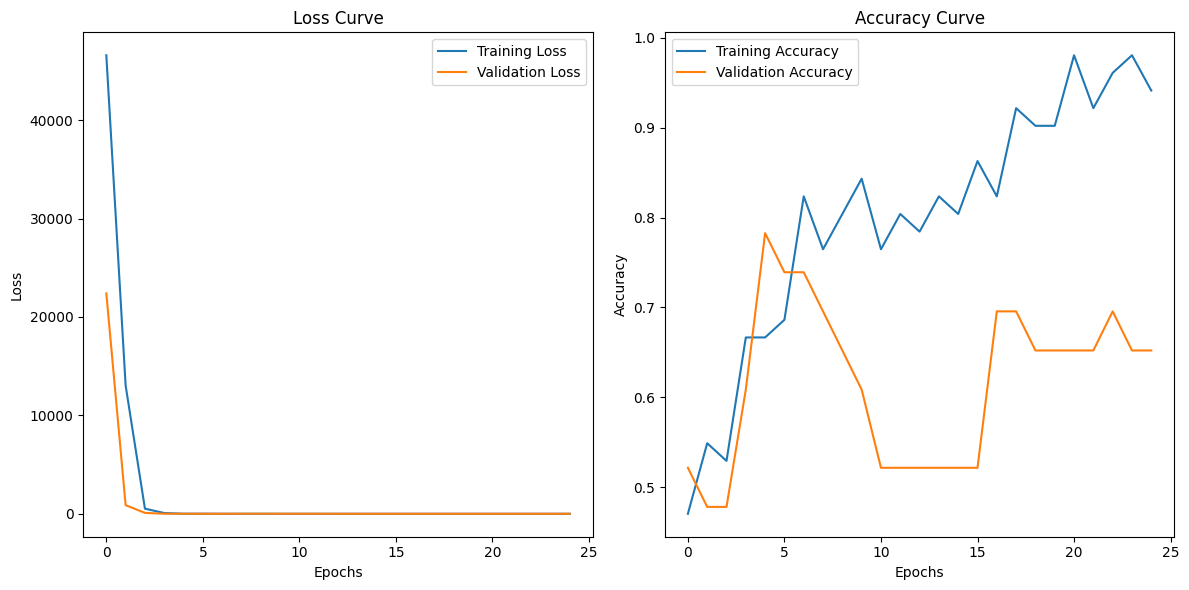

In [12]:
# Plotting training curves
def plot_training_curves(history_model_classic):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot loss
    axs[0].plot(history_model_classic.history['loss'], label="Training Loss")
    axs[0].plot(history_model_classic.history['val_loss'], label="Validation Loss")
    axs[0].set_title("Loss Curve")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend()

    # Plot accuracy
    axs[1].plot(history_model_classic.history['accuracy'], label="Training Accuracy")
    axs[1].plot(history_model_classic.history['val_accuracy'], label="Validation Accuracy")
    axs[1].set_title("Accuracy Curve")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

plot_training_curves(history_cnn3d)